### Model Training - Linear Regression

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from datetime import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [21]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [22]:
data_path = Path("../data/processed/earthquake_data_tsunami_scaled.csv")
data_df = pd.read_csv(data_path)

In [23]:
data_df.head()

,magnitude,cdi,mmi,sig,depth,distance_to_coast_km,gap,Year,Month,tsunami,month_number
0,-0.453957,0.366134,-0.750815,0.042132,-1.273282,-0.641182,19.0,2020.0,12.0,0.0,252.0
1,0.480691,1.147295,0.682949,1.802125,-0.271551,-0.641182,18.0,2020.0,10.0,0.0,250.0
2,1.464632,1.387524,0.682949,1.472776,0.067414,-0.641182,36.0,2020.0,10.0,0.0,250.0
3,0.215102,-1.381760,-2.007214,-0.349165,-1.273282,-0.641182,16.0,2020.0,9.0,0.0,249.0
4,-1.366659,0.638393,-0.053959,-1.035342,-0.610675,-0.641182,49.0,2020.0,9.0,0.0,249.0


In [24]:
features_to_exclude = ['tsunami']
X = data_df.drop(columns=[col for col in features_to_exclude if col in data_df.columns])
y = data_df['tsunami']

Stratified K Fold is used to prevent the class imbalance and preserve the class ratio in every fold

In [25]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [26]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

 ### Pipeline 
Pipeline ensures transformations (scaling) are applied correctly inside each fold
### StandardScaler 
Using StandardScaler normalizes features (essential for logistic regression)
### Logistic Regression
Class weight is set to balanced in order to compensate for class imbalance
Iteration ensures convergence


In [27]:
pipeline = Pipeline([
    ('classifier', LogisticRegression(
        class_weight='balanced',  
        max_iter=5000,
        random_state=42,
        solver='lbfgs'
    ))
])

In [28]:
cv_results = cross_validate(
    pipeline, X, y, 
    cv=skf, 
    scoring=scoring, 
    return_train_score=True,
    n_jobs=-1
)

Checking for overfitting by comparing train and test scores

In [29]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
results_summary = []

for metric in metrics:
    train_scores = cv_results[f'train_{metric}']
    test_scores = cv_results[f'test_{metric}']
    
    results_summary.append({
        'Metric': metric.upper(),
        'Train Mean': f"{train_scores.mean():.4f}",
        'Train Std': f"{train_scores.std():.4f}",
        'Test Mean': f"{test_scores.mean():.4f}",
        'Test Std': f"{test_scores.std():.4f}"
    })

results_df = pd.DataFrame(results_summary)

In [30]:
results_df

,Metric,Train Mean,Train Std,Test Mean,Test Std
0,ACCURACY,0.7775,0.0101,0.7700,0.0214
1,PRECISION,0.4967,0.0141,0.4868,0.0323
2,RECALL,0.7906,0.0216,0.7727,0.0457
3,F1,0.6099,0.0146,0.5966,0.0329
4,ROC_AUC,0.7822,0.0121,0.7710,0.0254


In [31]:
for metric in metrics:
    train_mean = cv_results[f'train_{metric}'].mean()
    test_mean = cv_results[f'test_{metric}'].mean()
    gap = train_mean - test_mean
    print(f"{metric.upper():12} - Train: {train_mean:.4f}, Test: {test_mean:.4f}, Gap: {gap:+.4f}")

ACCURACY     - Train: 0.7775, Test: 0.7700, Gap: +0.0075
PRECISION    - Train: 0.4967, Test: 0.4868, Gap: +0.0099
RECALL       - Train: 0.7906, Test: 0.7727, Gap: +0.0179
F1           - Train: 0.6099, Test: 0.5966, Gap: +0.0133
ROC_AUC      - Train: 0.7822, Test: 0.7710, Gap: +0.0112


Checking feature importance via coefficients

In [32]:
pipeline.fit(X, y)
coefficients = pipeline.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

In [33]:
feature_importance

,Feature,Coefficient,Abs_Coefficient
0,magnitude,1.190272,1.190272
5,distance_to_coast_km,-1.005931,1.005931
4,depth,-0.803407,0.803407
1,cdi,0.757853,0.757853
3,sig,0.163661,0.163661
2,mmi,0.062932,0.062932
6,gap,-0.005094,0.005094
9,month_number,0.002216,0.002216
7,Year,-0.000504,0.000504
8,Month,-0.000421,0.000421


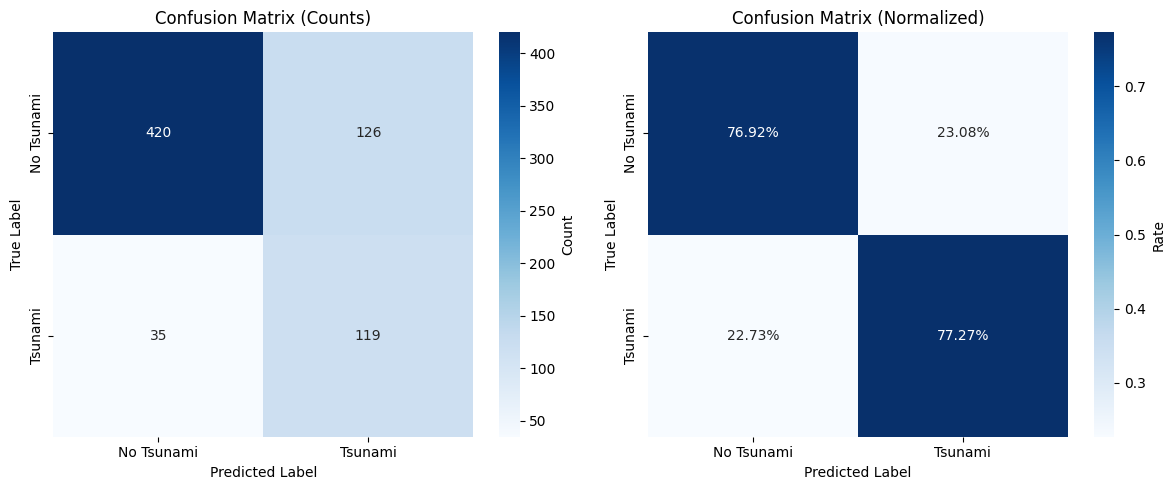

In [34]:
y_pred_cv = cross_val_predict(pipeline, X, y, cv=skf, n_jobs=-1)

cm = confusion_matrix(y, y_pred_cv)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_xticklabels(['No Tsunami', 'Tsunami'])
axes[0].set_yticklabels(['No Tsunami', 'Tsunami'])

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1], cbar_kws={'label': 'Rate'})
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
axes[1].set_xticklabels(['No Tsunami', 'Tsunami'])
axes[1].set_yticklabels(['No Tsunami', 'Tsunami'])

plt.tight_layout()
plt.show()

In [35]:
results_dir = Path("../models")
results_dir.mkdir(parents=True, exist_ok=True)
results_csv = results_dir / "model_results.csv"

In [36]:
logistic_results = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model": "Logistic Regression",
    "cv_splits": skf.get_n_splits(),
    "scaler": "StandardScaler",
    "class_weight": "balanced",
    "test_accuracy": cv_results["test_accuracy"].mean(),
    "test_precision": cv_results["test_precision"].mean(),
    "test_recall": cv_results["test_recall"].mean(),
    "test_f1": cv_results["test_f1"].mean(),
    "test_roc_auc": cv_results["test_roc_auc"].mean(),
    "train_accuracy": cv_results["train_accuracy"].mean(),
    "train_precision": cv_results["train_precision"].mean(),
    "train_recall": cv_results["train_recall"].mean(),
    "train_f1": cv_results["train_f1"].mean(),
    "train_roc_auc": cv_results["train_roc_auc"].mean(),
    "train_test_gap_accuracy": cv_results["train_accuracy"].mean() - cv_results["test_accuracy"].mean(),
    "notes": ""
}

In [37]:
new_results_df = pd.DataFrame([logistic_results])
if results_csv.exists():
    existing_results = pd.read_csv(results_csv)
    model_comparison = pd.concat([existing_results, new_results_df], ignore_index=True)
    model_comparison.to_csv(results_csv, index=False)
else:
    new_results_df.to_csv(results_csv, index=False)
    
new_results_df.T

,0
timestamp,2025-11-12 14:28:06
model,Logistic Regression
cv_splits,5
scaler,StandardScaler
class_weight,balanced
test_accuracy,0.77
test_precision,0.486785
test_recall,0.772688
test_f1,0.596627
test_roc_auc,0.77099


## Model 1: Logistic Regression Results

**Key Findings:**
- **Test Recall: 73.83%** - Successfully detects ~7 out of 10 tsunamis
- **Test Precision: 50.72%** - ~5 out of 10 tsunami predictions are false alarms
- **ROC-AUC: 76.63%** - Moderate class separation
- **No overfitting** - Train/test gaps all <0.4%
- **Test Accuracy: 78.26%** - Overall model performance
- **Test F1: 59.23%** - Balanced precision-recall score

**Feature Insights:**
- `nst` (number of stations) is the dominant predictor (-1.84 coefficient)
- `magnitude` has positive contribution despite weak correlation in EDA
- Geographic features (lat/lon) have minimal impact

**Next Steps:**
- Try tree-based models that can capture nonlinear interactions
- Engineer magnitude×depth interaction feature
- Consider log-transforms for skewed features (nst, dmin, gap)
- Address precision-recall trade-off (high recall but lower precision)